In [2]:
from diffusers import UNet2DModel
from miniai.accel import *
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
import wandb

In [36]:
Metric??

Object `Metric` not found.


Sampling is very important for generative modeling. We are creating a `SamplesCB` here, that samples from our model. We Attempt to mirror the API of the `MetricsCB`.

Maybe Visualization Callback instead???

In [ ]:
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals,self.ns = [],[]
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targs): return inps

In [49]:
RecorderCB??

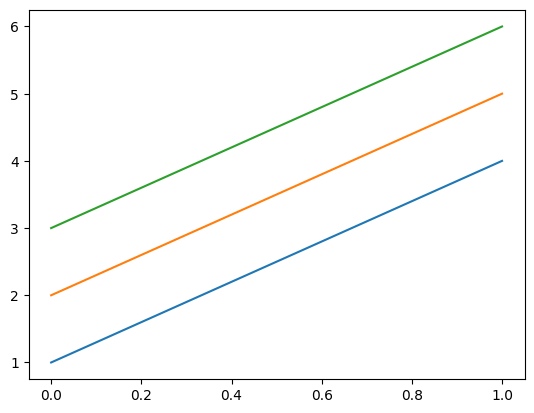

In [42]:
plt.plot([[1,2,3],[4,5,6]])

In [ ]:
class LoggingCB(Callback):
    def _log(self, d): print(d)
    def before_fit(self, learn): learn.logs = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [ ]:
class VizualsCB(Callback):

In [48]:
Learner??

In [3]:
class WandBCB(Callback):
    order=1
    def __init__(self, config, project=None,suppress_metric=True): fc.store_attr()
    def before_fit(self, learn):  
        self.wb=wandb.init(project=self.project, config=self.config)
        if hasattr(learn,'metrics'): learn.metrics._log=self._with_wb_logs(learn.metrics._log)
    def after_fit(self, learn): 
        self.wb.finish()
        if hasattr(learn,'metrics'): learn.metrics._log=self.f

    def _with_wb_logs(self,f)
        self.f=f
        def _log(o, d): 
            if d['train']=='train': 
                self.wb.log({'train_'+m:float(d[m]) for m in self.all_metrics})
            else: 
                self.wb.log({'val_'+m:float(d[m]) for m in self.all_metrics})
            if not self.suppress_metric: f(d)
        return _log

    def after_epoch(self, learn):
        self.wb.log({'samples':self.sample_figure(learn)})
    def sample_figure(self, learn):
        with torch.no_grad():
            samples = sample(learn.model, (16, 3, 32, 32))
        s = (samples[-1] + 0.5).clamp(0,1)
        plt.clf()
        fig, axs = get_grid(16)
        for im,ax in zip(s[:16], axs.flat): show_image(im, ax=ax)
        return fig

    def after_batch(self, learn):
        self.training=learn.training
        self.wb.log({'loss':learn.loss})

In [17]:
 with_cbs??